# **02 - Modelling**

En Xepelin estamos desarrollando un nuevo producto para las pymes de latinoamérica, y tu objetivo como miembro del equipo de Data es analizar los datos transaccionales disponible y generar un modelo que permita predecir cuánto dinero se pagará a través de este producto y cuanto se financiará por Xepelin.

**NOTE: Un modelo que prediga el flujo total a través del producto.**

**Otro modelo que prediga cuanto financiará por Xepelin**

En esta notebook se presenta el modelado.

Primero se crea un benchmark con reg lineal.

Luego se hace un linea de auto ML. Modelos de estadística clásicos

Y por ultimo un Fb prophet


## 00 - Dependencies

In [136]:
#Data Wrangling
import datetime
from math import sqrt
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#Visualización
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.style.use('bmh')
%matplotlib inline
import seaborn as sns
sns.set()

#Stats Time Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

#ML Time Series
from fbprophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## 01 - Dataset

In [137]:
df = pd.read_csv('dataset.csv')
df['paidAt']=pd.to_datetime(df['paidAt'])
#Truncate to days
df['paidAt']=df['paidAt'].dt.floor('d')

## 02 - Data Preprocessing

Como queremos determinar dinero que se pagará a través del producto y por otro lado, el financiado por Xepelin, nos quedaremos con las instancias que se han efectuado.

In [138]:
df = df[df['status'] == 'PAID']
df.set_index('paidAt',inplace=True)

Para el modelo de caudal total resampleo por Mes y Semana

In [139]:
total_month = df['amount'].resample('BMS').sum().to_frame()
total_week = df['amount'].resample('W', label='left', loffset=pd.DateOffset(days=1)).sum().to_frame()
total_day = df['amount'].resample('d').sum().to_frame()
total_day

,amount
paidAt,
2021-02-08,"2,410.72"
2021-02-09,0.00
2021-02-10,0.00
2021-02-11,0.00
2021-02-12,0.00
...,...
2021-09-26,0.00
2021-09-27,"7,061.70"
2021-09-28,0.00


Para el modelo de caudal financiado resampleo por Mes y Semana

In [140]:
xep_month = df['amountfinancedByXepelin'].resample('BMS').sum().to_frame()
xep_week = df['amountfinancedByXepelin'].resample('W', label='left', loffset=pd.DateOffset(days=1)).sum().to_frame()
xep_day = df['amountfinancedByXepelin'].resample('d').sum().to_frame()

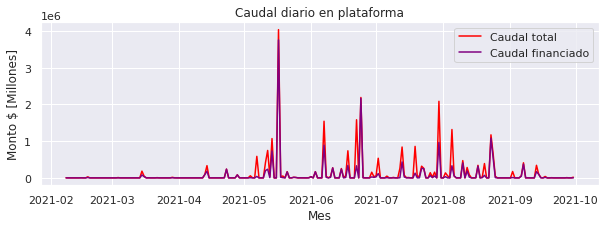

In [141]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(total_day, color = 'red') 
ax.plot(xep_day, color = 'purple') 
ax.set_xlabel("Mes")
ax.set_ylabel("Monto $ [Millones]")
ax.set_title("Caudal diario en plataforma")


ax.legend(["Caudal total", "Caudal financiado"])

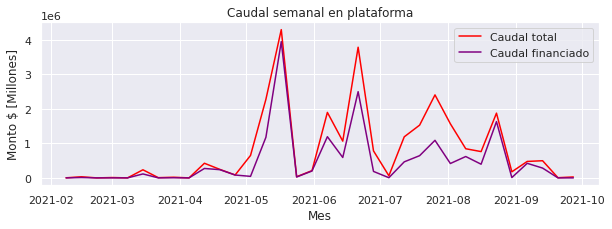

In [142]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(total_week, color = 'red') 
ax.plot(xep_week, color = 'purple') 
ax.set_xlabel("Mes")
ax.set_ylabel("Monto $ [Millones]")
ax.set_title("Caudal semanal en plataforma")


ax.legend(["Caudal total", "Caudal financiado"])

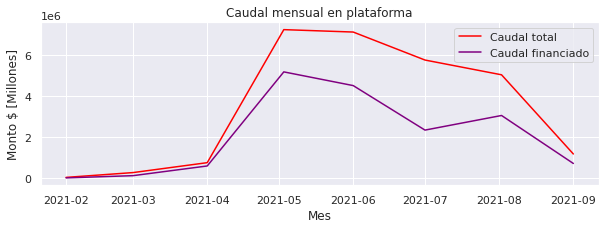

In [143]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(total_month, color = 'red') 
ax.plot(xep_month, color = 'purple') 
ax.set_xlabel("Mes")
ax.set_ylabel("Monto $ [Millones]")
ax.set_title("Caudal mensual en plataforma")


ax.legend(["Caudal total", "Caudal financiado"])

Disclaimer :

In [144]:
#Días en los que no hubo movimiento
dias_sin_caudal = total_day[total_day.amount==0].shape[0]
total_dias = total_day.shape[0]
per =round((dias_sin_caudal/total_dias)*100,2)
print(f'El {per}% de los días no hubieron movimientos')

El 54.89% de los días no hubieron movimientos


Esto nos habla un poco del sparcity del dataset y del posible pitfall que tendremos a la hora de modelar el caso.

Por un lado, va a estar sesgado al cero por la cantidad de instancias, y por otro lado, cualquier métrica de performance que usemos, por ejemplo el RMSE, va a dar descente dado que predecir 0 y que la etiqueta sea 0 también es muy probable (o que prediga un valor muy cercano, el error va a ser bajo.)

Dicho esto, voy a modelar unicamente en flujo semanal, que si bien no hay muchos data points, son consistentes 


### Data Preprocessing - Suavizando la muestra

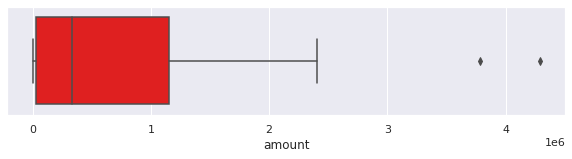

In [145]:
plt.figure(figsize = (10,2))
sns.boxplot(total_week.amount,color = 'red')
plt.show()

In [146]:
# Interpolo valores outliers
Q1 = total_week.amount.quantile(0.25)
Q3 = total_week.amount.quantile(0.75)
IQR = Q3 - Q1

total_week[(total_week.amount < (Q1 - 1.5*IQR)) | (total_week.amount > (Q3 + 1.5*IQR))] = np.nan
total_week = total_week.interpolate()

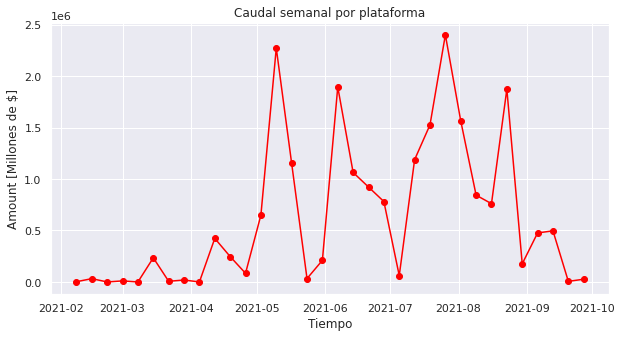

In [147]:
plt.figure(figsize = (10,5))
plt.plot(total_week.index, total_week.amount, 'o-', color = 'red')

plt.title('Caudal semanal por plataforma')
plt.xlabel('Tiempo')
plt.ylabel('Amount [Millones de $]')
plt.show()

## 02 - Benchmark

Empezamos el modelado con algunos benchmark. Van a ser nuestras soluciones mas "naive". Es el baseline que nuestro modelo debería superar para poder analizar si es viable la utilización y futura puesta en producción.

Dentro de los benchmark posibles elijo dos:
1. El valor de t-1 (valor anterior de la serie)
2. Regresión lineal

### A- Regresión lineal

La estrategia para este caso es la de one-step prediction

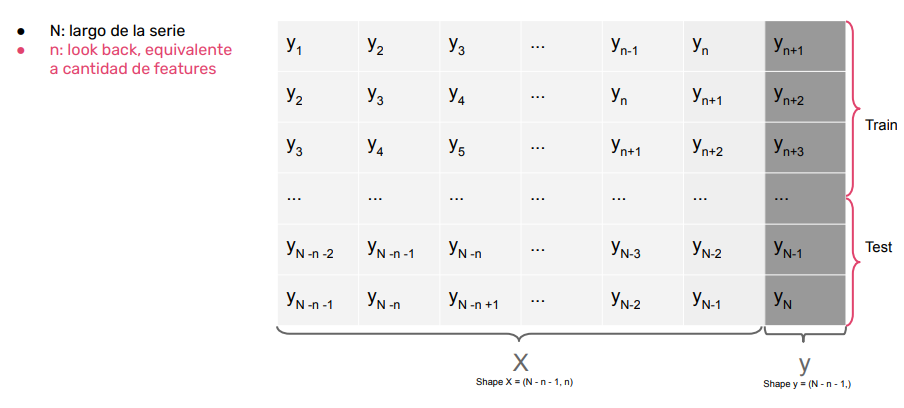

In [148]:
#Duplico para modificar
senial = total_week.amount
senial.shape[0]

34

In [149]:
look_back = 6

In [150]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(27, 6) (27,)


In [151]:
for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [152]:
N_train = 22 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 6#cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(16, 6) (16,)
(6, 6) (6,)


In [153]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train,y_train)

In [154]:
y_pred = reg.predict(X)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

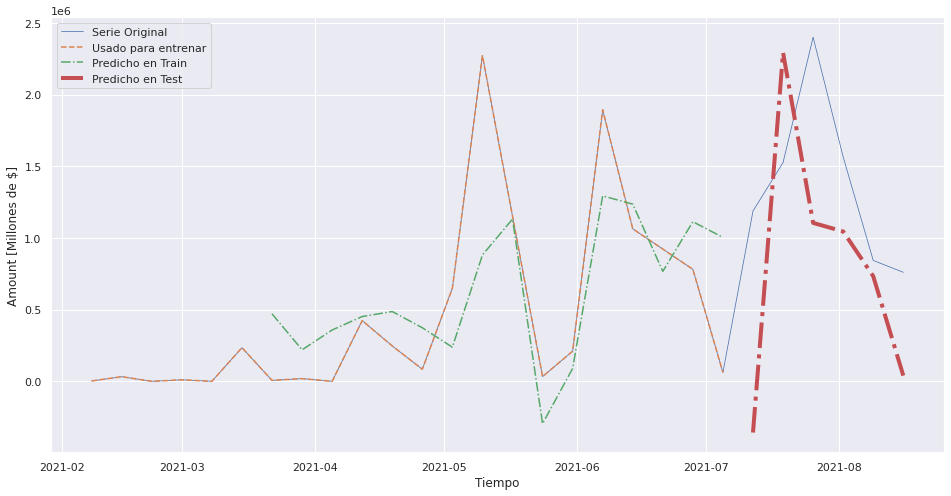

In [155]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amount [Millones de $]')
plt.show()

In [156]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Train: 510256.1759383754
Error en Test: 953871.6147406782


### B - Valor de t-1

In [157]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

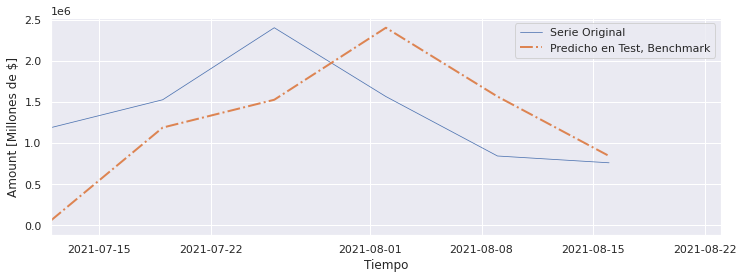

In [158]:

plt.figure(figsize=(12,4))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(senial.index[N_train+look_back], senial.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Amount [Millones de $]')
plt.legend()
plt.show()

In [159]:
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print(np.sqrt(MSE))

750008.1548226253


Finalmente obtuvimos los dos RMSE para los benchmark:

1. Regresión Lineal : 953.871

2. Valor t-1 : 750.008

##  **03 - Approach -Técnicas Tradicionales de pronóstico de series de tiempo**

Antes de aplicar cualquier modelo estadístico en Time Series, hay que verificar que la serie que estamos analizando es estacionaria. Esto quiere decir que en diferentes periodos de tiempo:

* Tiene una media constante

* Tiene una varianza o desviación estandard constante

* Auto-covarianza no debe depender del tiempo

La tendencia y la estacionalidad son dos razones por las que una serie temporal no es estacionaria y, por lo tanto, debe corregirse.



**Técnica para verificar si la serie es estacionaria**

Si bien, hay diferentes maneras de verificar esto. En este caso voy a utilizar ADCF Test - Augmented Dickey-Fuller test.

Este test se utiliza para darnos varios valores que pueden ayudar a identificar la estacionariedad. La hipótesis nula dice que un TS no es estacionario. Se compone de estadísticas de prueba y algunos valores críticos para algunos niveles de confianza. Si las estadísticas de prueba son menores que los valores críticos, podemos rechazar la hipótesis nula y decir que la serie es estacionaria. La prueba ADCF también nos da un valor p. Según la hipótesis nula, valores más bajos de p es mejor.

In [160]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=6).mean()
    movingSTD = timeseries.rolling(window=6).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='red', label='Original')
    mean = plt.plot(movingAverage, color='blue', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['amount'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

In [161]:
#Copio DS por transformaciones futuras
week = total_week[['amount']]
week.shape[0]

34

In [162]:
#Convierto los ceros a 1. Esto para cuando apliquemos logaritmo no convierta a infinito
week[week['amount'] ==0]=1

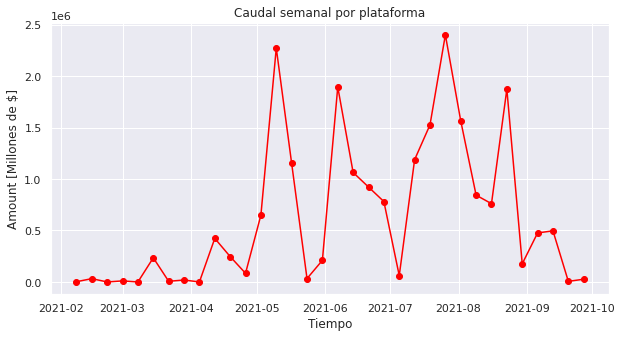

In [163]:
plt.figure(figsize = (10,5))
plt.plot(total_week.index, total_week.amount, 'o-', color = 'red')

plt.title('Caudal semanal por plataforma')
plt.xlabel('Tiempo')
plt.ylabel('Amount [Millones de $]')
plt.show()

In [164]:
#Determinamos rolling statistics
rolmean = week.rolling(window=6).mean() 
rolstd = week.rolling(window=6).std()

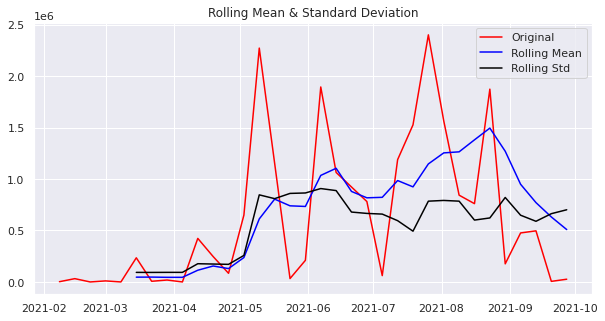

In [165]:
#Plot rolling statistics
plt.figure(figsize = (10,5))
orig = plt.plot(week, color='red', label='Original')
mean = plt.plot(rolmean, color='blue', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [166]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(week['amount'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -3.34
p-value                        0.01
#Lags Used                     0.00
Number of Observations Used   33.00
Critical Value (1%)           -3.65
Critical Value (5%)           -2.95
Critical Value (10%)          -2.62
dtype: float64


Para que una serie de tiempo sea estacionaria, su prueba ADCF debe tener:



1.   Valor p bajo (según la hipótesis nula)
2.   Los valores críticos en intervalos de confianza del 1 %, 5 % y 10 % deben estar lo más cerca posible de las estadísticas de prueba.



Del resultado de la prueba ADCF anterior, vemos que el valor p es muy bajo. Además, los valores críticos están cerca de las estadísticas de prueba. Por lo tanto, podemos decir con seguridad que nuestra serie temporal en este momento es estacionaria

### Técnicas de Time Shifting

Teniendo una observación en el tiempo como 
`x0,x1,x2,x3,....xn `

Los shifted values serán : 
`null,x0,x1,x2,....xn`  <---- Básicamente las Xi se desplazan un lugar hacia la derecha.

Así, las series de tiempo con valores desplazados en el tiempo son:
`null,(x1−x0),(x2−x1),(x3−x2),(x4−x3),....(xn−xn−1)`

In [167]:
week_shifting = week - week.shift()
week_shifting.dropna(inplace=True)

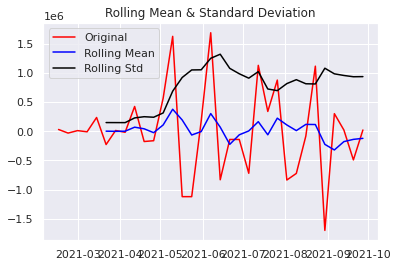

Results of Dickey Fuller Test:
Test Statistic                -5.58
p-value                        0.00
#Lags Used                     2.00
Number of Observations Used   30.00
Critical Value (1%)           -3.67
Critical Value (5%)           -2.96
Critical Value (10%)          -2.62
dtype: float64


In [168]:
test_stationarity(week_shifting)

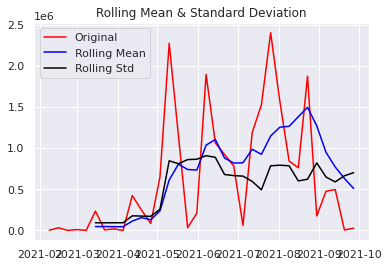

Results of Dickey Fuller Test:
Test Statistic                -3.34
p-value                        0.01
#Lags Used                     0.00
Number of Observations Used   33.00
Critical Value (1%)           -3.65
Critical Value (5%)           -2.95
Critical Value (10%)          -2.62
dtype: float64


In [169]:
test_stationarity(week)

### ACF y PACF

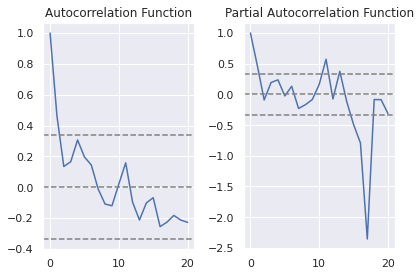

In [170]:
#ACF & PACF plots

lag_acf = acf(week, nlags=20)
lag_pacf = pacf(week, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(week)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(week)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(week)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(week)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()  

### Building Models - AR , MA y ARIMA

Text(0.5, 1.0, 'AR model')

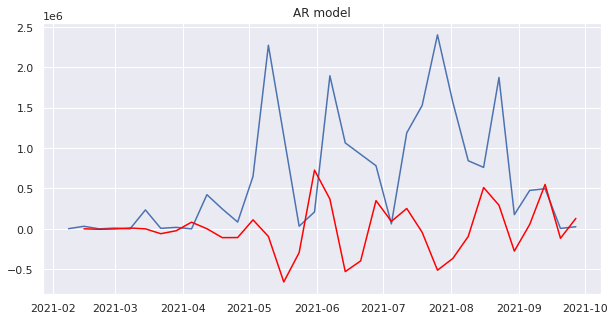

In [171]:
#AR Model
plt.figure(figsize = (10,5))
model = ARIMA(week, order=(2,1,0))
results_AR = model.fit(disp=-1)

plt.plot(week)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('AR model')

Text(0.5, 1.0, 'MA')

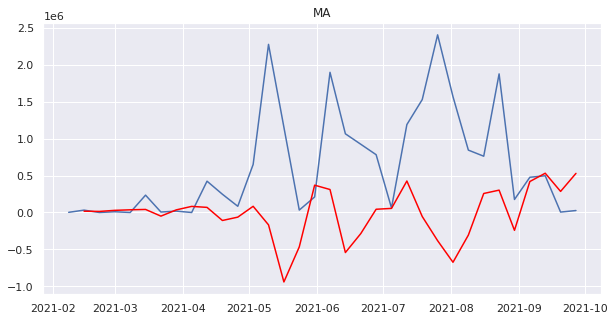

In [172]:
#MA Model
plt.figure(figsize = (10,5))
model = ARIMA(week, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(week)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA')

Text(0.5, 1.0, 'ARIMA')

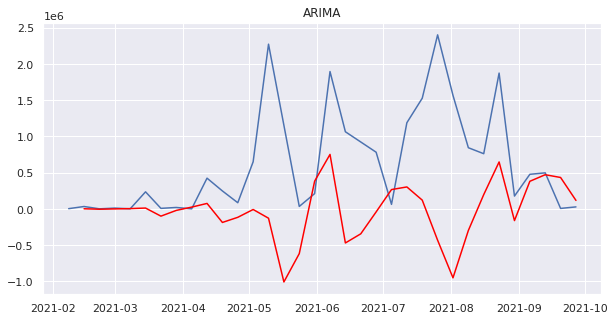

In [173]:
# AR+I+MA = ARIMA model
plt.figure(figsize = (10,5))
model = ARIMA(week, order=(5,1,0))
results_ARIMA = model.fit(disp=-1)
plt.plot(week)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA')

Estas son celdas para la transformación del output

In [174]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

paidAt
2021-02-15      731.92
2021-02-22   -5,217.39
2021-03-01   -1,113.21
2021-03-08    3,108.98
2021-03-15   10,556.43
dtype: float64


In [175]:
#Convertimos a suma acumulativa
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

paidAt
2021-02-15          731.92
2021-02-22       -4,485.47
2021-03-01       -5,598.68
2021-03-08       -2,489.70
2021-03-15        8,066.72
2021-03-22      -92,924.40
2021-03-29     -114,635.11
2021-04-05      -90,994.26
2021-04-12      -16,581.82
2021-04-19     -204,561.77
2021-04-26     -321,718.46
2021-05-03     -331,015.63
2021-05-10     -460,597.34
2021-05-17   -1,469,695.09
2021-05-24   -2,088,010.25
2021-05-31   -1,706,349.38
2021-06-07     -955,438.26
2021-06-14   -1,426,590.57
2021-06-21   -1,771,687.06
2021-06-28   -1,814,513.33
2021-07-05   -1,548,813.32
2021-07-12   -1,246,861.16
2021-07-19   -1,126,898.52
2021-07-26   -1,560,095.06
2021-08-02   -2,512,332.92
2021-08-09   -2,810,996.68
2021-08-16   -2,614,750.24
2021-08-23   -1,967,848.59
2021-08-30   -2,130,124.23
2021-09-06   -1,750,178.48
2021-09-13   -1,279,520.38
2021-09-20     -847,052.74
2021-09-27     -731,025.63
dtype: float64


In [176]:
predictions_ARIMA_log = pd.Series(week['amount'].iloc[0], index=week.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

paidAt
2021-02-08    2,410.72
2021-02-15    3,142.64
2021-02-22   -2,074.75
2021-03-01   -3,187.96
2021-03-08      -78.98
dtype: float64

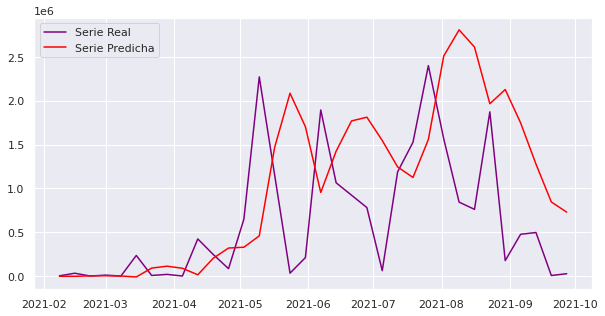

In [177]:
# Inverse of log is exp.
plt.figure(figsize = (10,5))
predictions_ARIMA = -(predictions_ARIMA_log)
plt.plot(week, color = 'purple')
plt.plot(predictions_ARIMA,'red')
plt.legend(['Serie Real', 'Serie Predicha'])
 #plt.ylim((-100,5000000))

### ARIMA Model

Separamos en train y test para poder cuantificar errores

In [178]:
#Split dataset
X = week.amount
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

predicted=171013.843086, expected=1188208.630000
predicted=1863940.309354, expected=1526229.280000
predicted=1055107.584024, expected=2400834.480000
predicted=1301629.463785, expected=1565385.470000
predicted=1154848.672067, expected=843157.190000
predicted=1066656.540442, expected=760622.260000
predicted=1804426.576015, expected=1873234.770000
predicted=2200752.847118, expected=175950.280000
predicted=908630.023826, expected=476115.660000
predicted=1129881.538160, expected=496546.560000
predicted=1217607.891879, expected=5612.180000
predicted=152015.901084, expected=26563.940000
Test RMSE: 884943.704


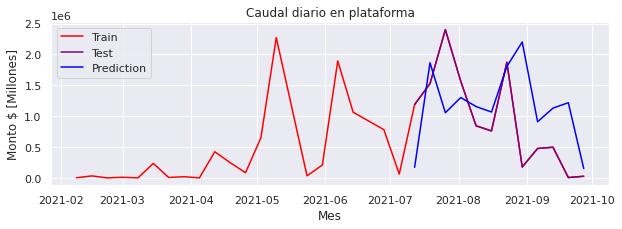

In [179]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(week,color = 'red')
ax.plot(test,color = 'purple')
predictions = pd.Series(predictions,index = test.index)
ax.plot(predictions, color='blue')
ax.set_xlabel("Mes")
ax.set_ylabel("Monto $ [Millones]")
ax.set_title("Caudal diario en plataforma")
ax.legend(["Train", "Test","Prediction"])

**El RMSE total es 881.095.**

Mejor que la regresión lineal, pero el valor de t-1 (benchmark 2) sigue siendo superior

## **04 - Approach : Machine Learning para series de tiempo**

En este enfoque de Machine Learning voy a entrenar modelos regresión a través de estrategias de One-Step y Multi-step prediction.

Después resolveremos el mismo problema con la librería de Facebook, Prophet.

Por último, utilizaré una librería de Low-Code Machine learning llamada pycaret para ver si alguno de los modelos que nos ofrece tiene performance superior que las opciones analizadas.

### **A - One-Step Prediction**

In [180]:
senial = total_week.amount
senial.head()

paidAt
2021-02-08    2,410.72
2021-02-15   32,014.46
2021-02-22        0.00
2021-03-01   10,165.86
2021-03-08        0.00
Name: amount, dtype: float64

In [181]:
look_back = 6

In [182]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(27, 6) (27,)


In [183]:
for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [184]:
N_train = 22 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 6#cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(16, 6) (16,)
(6, 6) (6,)


In [185]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

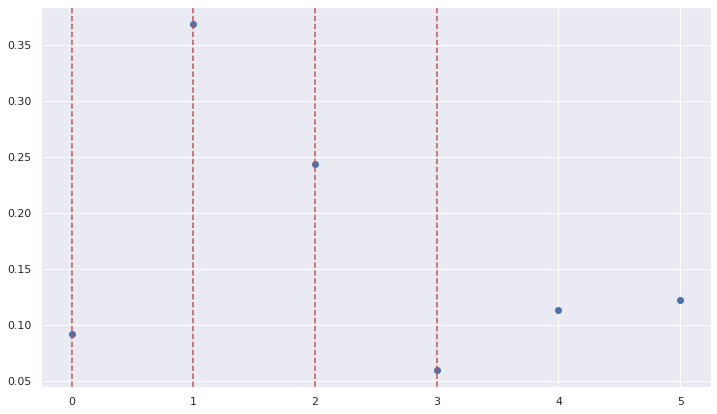

In [186]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
for x in np.arange(4):
     plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

In [187]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

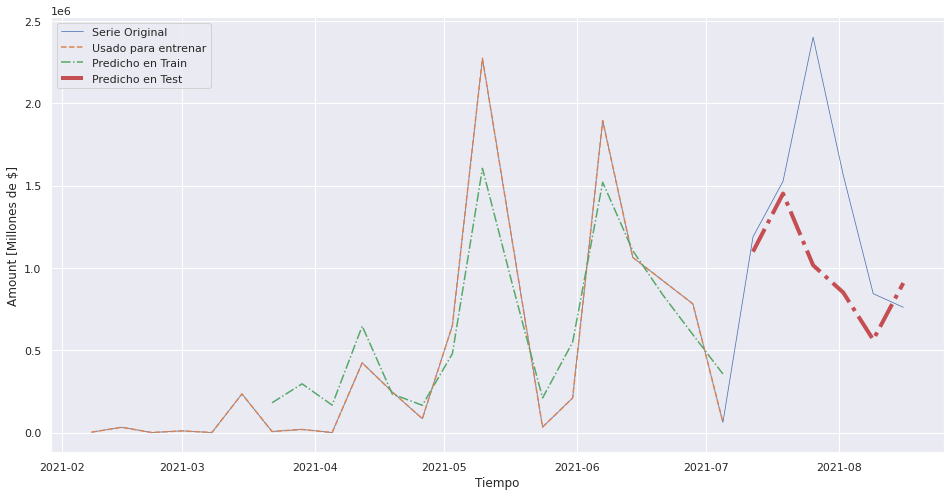

In [188]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amount [Millones de $]')
plt.show()

In [189]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Train: 268012.4835770741
Error en Test: 650939.7053630971


### B - Multi-Step Prediction

In [190]:
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = rf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

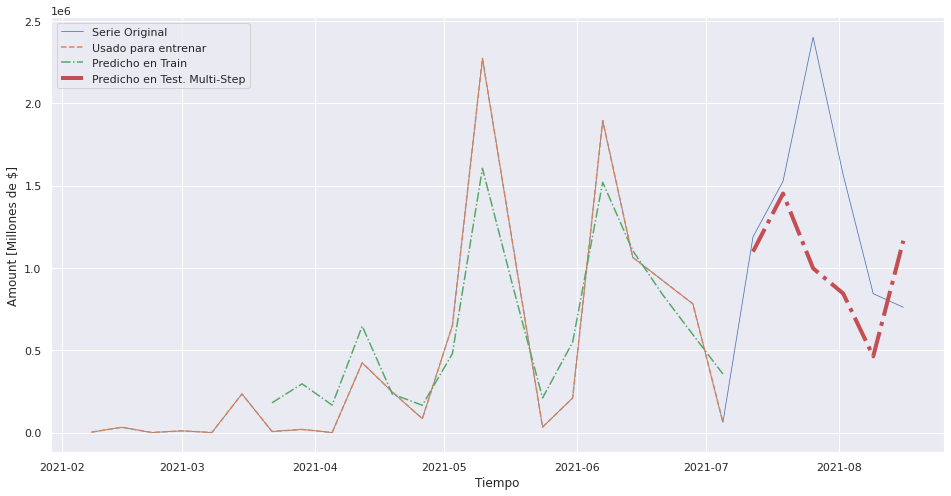

In [191]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amount [Millones de $]')
plt.show()

In [192]:
MSE = mean_squared_error(y_test, y_ms_test_pred)
print('Error en Train:',np.sqrt(MSE))

Error en Train: 684588.6585783161


### **C - Facebook Prophet**

In [193]:
total_week.reset_index(inplace=True)
prophet_df = total_week[["paidAt", "amount"]]
prophet_df = prophet_df.rename(columns = {"paidAt":"ds", "amount":"y"})

In [194]:
from prophet import Prophet
def build_model():
    """Define forecasting model."""

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,  
        interval_width=0.95, 
        mcmc_samples = 500
    )

    model.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=5
    )
    
    return model
    
model = build_model()

In [195]:
from prophet import Prophet
model = Prophet()
model.fit(prophet_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [196]:
future = model.make_future_dataframe(periods = 30)
forecast = model.predict(future)


In [197]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-08,"193,496.91","-649,131.82","982,451.29","193,496.91","193,496.91",0.00,0.00,0.00,0.00,0.00,0.00,"193,496.91"
1,2021-02-15,"219,981.98","-629,055.20","1,091,842.76","219,981.98","219,981.98",0.00,0.00,0.00,0.00,0.00,0.00,"219,981.98"
2,2021-02-22,"246,467.06","-619,110.41","1,055,729.56","246,467.06","246,467.06",0.00,0.00,0.00,0.00,0.00,0.00,"246,467.06"
3,2021-03-01,"272,952.13","-524,413.63","1,151,391.67","272,952.13","272,952.13",0.00,0.00,0.00,0.00,0.00,0.00,"272,952.13"
4,2021-03-08,"299,437.20","-624,241.29","1,148,878.65","299,437.20","299,437.20",0.00,0.00,0.00,0.00,0.00,0.00,"299,437.20"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2021-10-23,"1,165,864.38","311,958.18","1,992,198.41","1,165,864.18","1,165,864.62",0.00,0.00,0.00,0.00,0.00,0.00,"1,165,864.38"
60,2021-10-24,"1,169,647.82","312,734.82","2,017,631.34","1,169,647.61","1,169,648.08",0.00,0.00,0.00,0.00,0.00,0.00,"1,169,647.82"
61,2021-10-25,"1,173,431.27","303,181.12","2,083,098.09","1,173,431.05","1,173,431.54",0.00,0.00,0.00,0.00,0.00,0.00,"1,173,431.27"
62,2021-10-26,"1,177,214.71","336,325.21","1,993,217.46","1,177,214.48","1,177,215.00",0.00,0.00,0.00,0.00,0.00,0.00,"1,177,214.71"


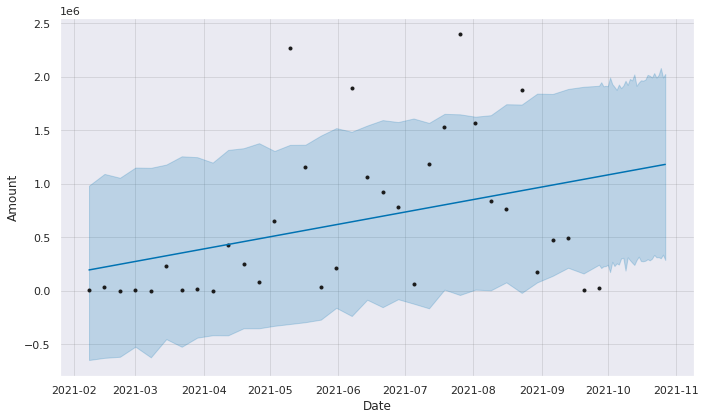

In [198]:
figure = model.plot(forecast, xlabel="Date", ylabel="Amount")

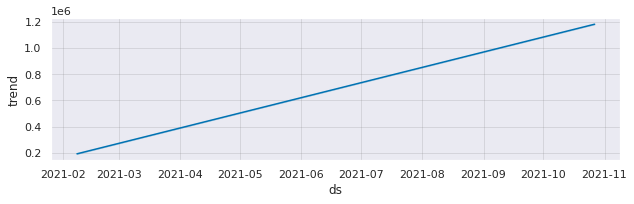

In [199]:
figure2 = model.plot_components(forecast)

No es capaz de generalizar con la cantidad de puntos del dataset.

### **D - PyCaret**

In [200]:
!pip install pycaret

In [201]:
week.reset_index(inplace=True)
week.dropna(inplace=True)

In [202]:
week['month'] = week['paidAt'].dt.month
week['year'] = week['paidAt'].dt.year
week['day_of_week'] = week['paidAt'].dt.day_of_week
week['day_of_year'] = week['paidAt'].dt.day_of_year

In [203]:
train = week[week['month']<8]
test = week[week['month']>=8]

In [204]:
pycaret_test = week[["paidAt", "amount",'month',	'year',	'day_of_week',	'day_of_year']]
pycaret_test.drop(columns = ['paidAt'],inplace = True)
train = pycaret_test[pycaret_test['month']<8]
test = pycaret_test[pycaret_test['month']>=8]

In [205]:
from pycaret.regression import *

s = setup(data = train, test_data = test,
          target = 'amount', 
          fold_strategy = 'timeseries',
          numeric_features = ['month', 'year','day_of_week','day_of_year'],
          fold = 3,
          transform_target = True,
          session_id = 123, silent = True,
          log_experiment = True, experiment_name = 'amount')

,Description,Value
0,session_id,123
1,Target,amount
2,Original Data,"(25, 5)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(25, 4)"


INFO:logs:Logging experiment in MLFlow
INFO:logs:SubProcess save_model() called ==================================
INFO:logs:Initializing save_model()
INFO:logs:save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=['month', 'year',
                                                          'day_of_week',
                                                          'day_of_year'],
                                      target='amount', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('

In [206]:
best = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,"532,647.64","497,446,751,005.90","659,996.77",-0.43,2.43,359.03,0.02
et,Extra Trees Regressor,"532,647.64","497,446,751,005.90","659,996.77",-0.43,2.43,359.03,0.19
gbr,Gradient Boosting Regressor,"533,678.88","499,956,685,737.46","661,292.71",-0.43,2.43,358.77,0.04
ada,AdaBoost Regressor,"557,786.58","580,825,237,957.88","701,500.15",-0.56,2.45,358.71,0.07
rf,Random Forest Regressor,"564,924.02","620,107,108,625.25","718,591.52",-0.60,2.40,827.16,0.27
knn,K Neighbors Regressor,"686,546.10","910,650,842,466.14","865,037.45",-1.13,2.96,92.66,0.09
br,Bayesian Ridge,"816,676.05","1,142,289,683,530.52","963,577.82",-1.63,2.69,173.70,0.02
lasso,Lasso Regression,"836,217.02","1,217,602,532,693.33","979,675.96",-1.79,2.52,379.57,0.02
llar,Lasso Least Angle Regression,"801,140.88","1,208,225,550,218.02","994,127.72",-1.68,3.82,158.03,0.02
dummy,Dummy Regressor,"801,140.88","1,208,225,550,905.32","994,127.72",-1.68,3.82,158.03,0.02


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:PowerTransformedTargetRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                presort='deprecated', random_state=123,
                                regressor=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                criterion='mse',
                                                                max_depth=None,
                                  

El mejor es un DecissionTreeRegressor con un RMSE de 659.996

## 05 - Conclusión

Finalmente tenemos lo siguiente:

**Benchmark**
1. Regresión Lineal : 953.871

2. Valor t-1 : 750.008

**Traditional Time Series**
1. ARIMA : 881.095

**Machine Learning**
1. Random Forest (OSP): 650.939
2. Random Forest (MSP): 684.588
3. Prophet: **Test cancelado**
4. PyCaret: 659.996

Mi elección final es el Random Forest utilizando One-Step Prediction. Además de que el performance superó el performance, es un modelo más simple tanto desde la aplicabilidad como la interpretación del mismo.
